## ITO Anode

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import cmath

In [2]:
d = [float("inf"), 130, 50, 110, float("inf")]

ito_eta = []
ito_k = []
ito_wavelengths = []
for line in open('data/nk_ITO.csv'):
    row = line.strip().split(',')
    if row[0].isdigit():
        ito_wavelengths.append(int(row[0]))
        ito_eta.append(float(row[1]))
        ito_k.append(float(row[2]))
ito_n = np.array(ito_eta) + 1j*np.array(ito_k) # complex indices of refraction
ito_q = ito_n # since we are assuming that the angle of incidence is 0
ito_q = dict(zip(ito_wavelengths, ito_q))

In [3]:
pedot_eta = []
pedot_k = []
pedot_wavelengths = []
for line in open('data/nk_PEDOT.csv'):
    row = line.strip().split(',')
    if row[0].isdigit():
        pedot_wavelengths.append(int(row[0]))
        pedot_eta.append(float(row[1]))
        pedot_k.append(float(row[2]))
pedot_n = np.array(pedot_eta) + 1j*np.array(pedot_k) # complex indices of refraction
pedot_q = pedot_n # since we are assuming that the angle of incidence is 0
pedot_q = dict(zip(pedot_wavelengths, pedot_q))

In [4]:
p3ht_eta = []
p3ht_k = []
p3ht_wavelengths = []
for line in open('data/nk_P3HTPCBM_BHJ.csv'):
    row = line.strip().split(',')
    if row[0].isdigit():
        p3ht_wavelengths.append(int(row[0]))
        p3ht_eta.append(float(row[1]))
        p3ht_k.append(float(row[2]))
p3ht_n = np.array(p3ht_eta) + 1j*np.array(p3ht_k) # complex indices of refraction
p3ht_q = np.array(p3ht_n) # since we are assuming that the angle of incidence is 0
p3ht_q = dict(zip(p3ht_wavelengths, p3ht_q))

In [6]:
ambient_eta = np.ones(len(p3ht_wavelengths))*0.13
ambient_k = np.ones(len(p3ht_wavelengths))*2.92
ambient_n = np.array(ambient_eta) + 1j*np.array(ambient_k) # complex indices of refraction
ambient_q = np.array(ambient_n) # since we are assuming that the angle of incidence is 0
ambient_q = dict(zip(p3ht_wavelengths, ambient_q))

device_q = [ambient_q, ito_q, pedot_q, p3ht_q, ambient_q]


In [7]:
# Returns the scattering matrix corresponding to the given layers
def scattering_matrix(start_layer, stop_layer, trans, refl, thick, phase):
    prod = np.identity(2) # initial value of cumulative product
    for v in range(start_layer, stop_layer+1):
        # interface matrix I_(v-1)v
        t_jk = trans[v-1]
        r_jk = refl[v-1]
        I_v = (1 / t_jk) * np.array([
                                        [1, r_jk], 
                                        [r_jk, 1]
                                    ]) 

        # layer matrix L_v
        phase_thickness = phase[v] * thick[v]
        L_v = np.array([
                            [cmath.exp(-1j*phase_thickness), 0],
                            [0, cmath.exp(1j*phase_thickness)]
                       ])

        inner_prod = np.matmul(I_v, L_v)

        prod = np.matmul(prod, inner_prod) # update cumulative product

    outer_interface = (1 / trans[start_layer]) * np.array([
                                                            [1, refl[start_layer]],
                                                            [refl[start_layer], 1]
                                                         ])
    return np.matmul(prod, outer_interface)

In [8]:
wavelengths = pedot_wavelengths
R = []
T = []
for lambdie in wavelengths:
    # Fresnel complex coefficients
    # t[0] corresponds to t_01 in the above theory
    t = [] # transmission
    r = [] # reflection

    for j in range(len(device_q) - 1):
        k = j+1
        t_jk = (2 * device_q[j][lambdie]) / (device_q[j][lambdie] + device_q[k][lambdie])
        r_jk = (device_q[j][lambdie] - device_q[k][lambdie]) / (device_q[j][lambdie] + device_q[k][lambdie])
        t.append(t_jk)
        r.append(r_jk)

    t = np.array(t)
    r = np.array(r)
    xi = np.zeros(len(device_q), dtype=complex)
    for layer in range(len(device_q)-1):
        xi[layer] = device_q[layer][lambdie] * (2 * math.pi / lambdie)
    xi[0] = float("inf")
    
    S = scattering_matrix(start_layer=1, stop_layer=3, trans=t, refl=r, thick=d, phase=xi)
    r_complex = S[0][1] / S[0][0]
    reflectivity = np.abs(r_complex)**2
    R.append(reflectivity)
    T.append(1 - reflectivity)

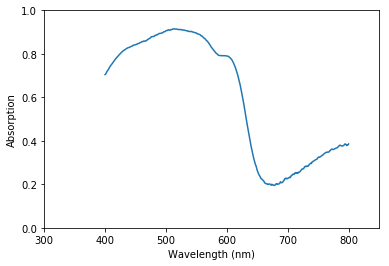

In [9]:
plt.plot(wavelengths[100:], T[100:])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorption")
plt.ylim(0, 1)
plt.xlim(300, 850)

plt.show()

## PEDOT:PSS Anode

In [10]:
d = [float("inf"), 150, 110, float("inf")]

pedot_anode_eta = []
pedot_anode_k = []
pedot_anode_wavelengths = []
for line in open('data/nk_PEDOT.csv'):
    row = line.strip().split(',')
    if row[0].isdigit():
        pedot_anode_wavelengths.append(int(row[0]))
        pedot_anode_eta.append(float(row[1]))
        pedot_anode_k.append(float(row[2]))
pedot_anode_n = np.array(pedot_anode_eta) + 1j*np.array(pedot_anode_k) # complex indices of refraction
pedot_anode_q = pedot_anode_n # since we are assuming that the angle of incidence is 0
pedot_anode_q = dict(zip(pedot_anode_wavelengths, pedot_anode_q))

In [15]:
pedot_device_q = [ambient_q, pedot_anode_q, p3ht_q, ambient_q]

In [20]:
wavelengths = pedot_wavelengths
R = []
T = []
for lambdie in wavelengths:
    # Fresnel complex coefficients
    # t[0] corresponds to t_01 in the above theory
    t = [] # transmission
    r = [] # reflection

    for j in range(len(pedot_device_q) - 1):
        k = j+1
        t_jk = (2 * pedot_device_q[j][lambdie]) / (pedot_device_q[j][lambdie] + pedot_device_q[k][lambdie])
        r_jk = (pedot_device_q[j][lambdie] - pedot_device_q[k][lambdie]) / (pedot_device_q[j][lambdie] + pedot_device_q[k][lambdie])
        t.append(t_jk)
        r.append(r_jk)

    t = np.array(t)
    r = np.array(r)
    xi = np.zeros(len(pedot_device_q), dtype=complex)
    for layer in range(len(pedot_device_q)-1):
        xi[layer] = pedot_device_q[layer][lambdie] * (2 * math.pi / lambdie)
    xi[0] = float("inf")
    
    S = scattering_matrix(start_layer=1, stop_layer=2, trans=t, refl=r, thick=d, phase=xi)
    r_complex = S[0][1] / S[0][0]
    reflectivity = np.abs(r_complex)**2
    R.append(reflectivity)
    T.append(1 - reflectivity)

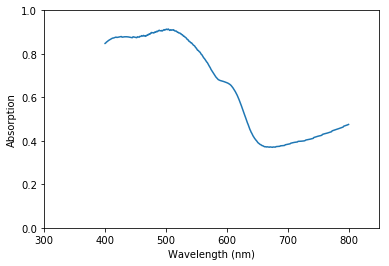

In [21]:
plt.plot(wavelengths[100:], T[100:])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorption")
plt.ylim(0, 1)
plt.xlim(300, 850)

plt.show()